In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler, TensorDataset
import numpy as np
import io
import imageio
import matplotlib.pyplot as plt
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets.utils import download_url
import random
import os
import wandb
import tqdm
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F


In [9]:
from torch.utils.tensorboard import SummaryWriter

In [10]:
writer = SummaryWriter('runs/conv_vae_mnist_static_regen_experiment')

In [11]:
# Function to download the dataset
def download_mnist(root="."):
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root=root, train=True, download=True, transform=transform)
    val_dataset = datasets.MNIST(root=root, train=False, download=True, transform=transform)
    return train_dataset, val_dataset

In [12]:
# Downloading the MNIST dataset
train_dataset, val_dataset = download_mnist()

In [13]:
# Creating DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [15]:
capacity = 64  # capacity of the VAE bottleneck(controlling the number of filters)
latent_dims = 20  # latent space dimension
learning_rate = 1e-3
num_epochs = 50

In [16]:
# Define the Encoder module
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)  # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)  # out: c*2 x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # flatten batch of multi-channel feature maps to a batch of feature vectors
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the Decoder module
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7)  # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x))  # last layer before output is tanh, since the images are normalized and 0-centered
        return x

In [17]:
# Define the VAE module
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [18]:
# Define the loss function for VAE
def vae_loss(x, recon_x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

In [19]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# Define the model
model = VAE().to(device)

In [21]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 647081


In [22]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [23]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

encoder.conv1.weight tensor([[[[ 0.0427,  0.0485, -0.0350, -0.0613],
          [-0.0926,  0.2221,  0.0593, -0.2481],
          [-0.0963,  0.1898, -0.0099, -0.0192],
          [-0.2243, -0.2309, -0.0883,  0.0725]]],


        [[[-0.2494,  0.2309, -0.0428, -0.0011],
          [-0.0008, -0.1989,  0.1152,  0.1981],
          [ 0.1018,  0.0349,  0.1859, -0.1306],
          [-0.0792,  0.2110,  0.1444, -0.0044]]],


        [[[-0.2237, -0.1675,  0.1318, -0.1045],
          [ 0.1039,  0.2112,  0.1668,  0.1900],
          [-0.0921,  0.0389, -0.1560, -0.1250],
          [ 0.2266,  0.1442,  0.1720, -0.0739]]],


        ...,


        [[[ 0.2266,  0.1533, -0.0983,  0.0280],
          [ 0.1514, -0.1140, -0.0153, -0.0843],
          [-0.0542,  0.0549,  0.0383,  0.1735],
          [ 0.2248,  0.0339,  0.0727,  0.2195]]],


        [[[-0.0887,  0.1228, -0.0988,  0.1324],
          [ 0.0222,  0.0381, -0.2455,  0.0504],
          [ 0.2317, -0.0188, -0.2257,  0.0936],
          [ 0.0348, -0.2017, -0.0367

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/50:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/50:  98%|█████████▊| 460/469 [00:06<00:00, 89.47it/s, loss=6.04e+3]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/50: 100%|██████████| 469/469 [00:06<00:00, 72.73it/s, loss=6.04e+3]


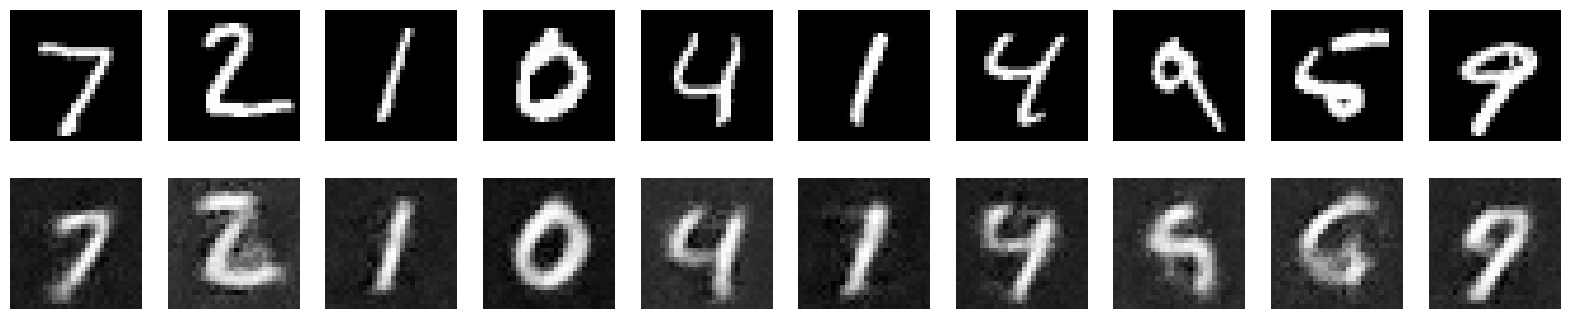

Epoch 11/50: 100%|██████████| 469/469 [00:05<00:00, 86.78it/s, loss=3.89e+3]


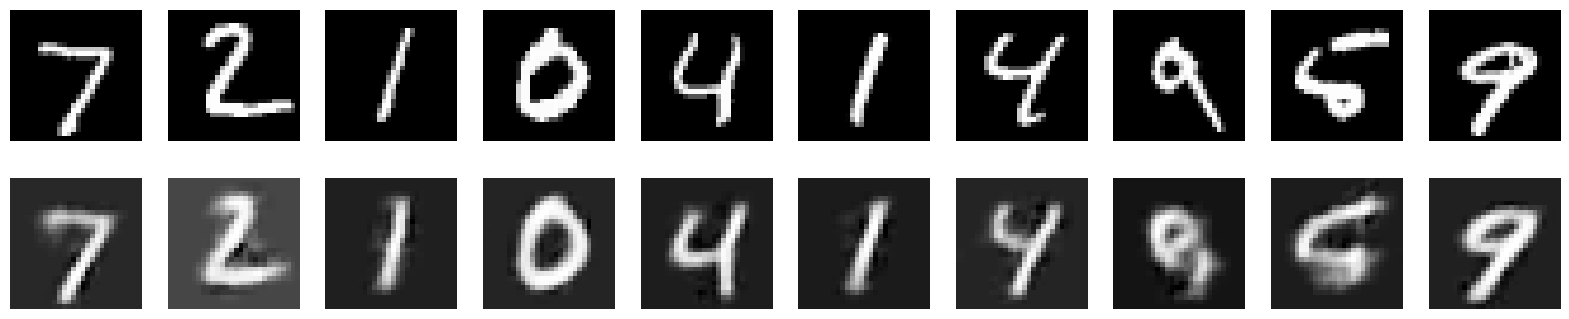

Epoch 41/50: 100%|██████████| 469/469 [00:05<00:00, 87.05it/s, loss=3.74e+3]


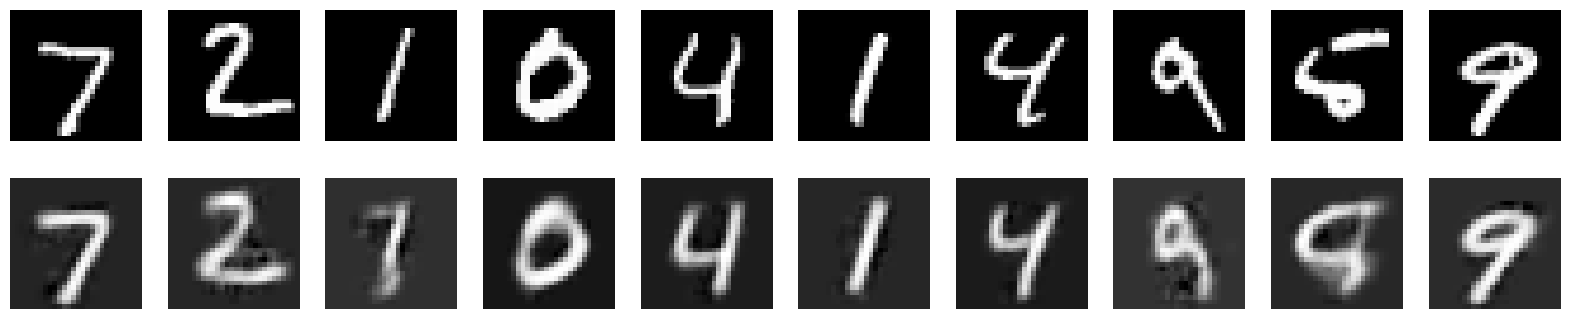

Epoch 43/50:  75%|███████▌  | 352/469 [00:04<00:01, 73.45it/s, loss=3.74e+3]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
# Train the VAE model
def train(model, train_dataloader, val_dataloader, optimizer, epochs, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler()  # Initialize GradScaler
    best_loss = float('inf')
    writer = SummaryWriter()  # Initialize SummaryWriter for TensorBoard
    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch, _ in pbar:
            batch = batch.to(device)  # Send the batch to the device
            optimizer.zero_grad()
            # Use autocast for mixed precision training
            with torch.cuda.amp.autocast():
                recon_x, mu, logvar = model(batch)
                loss = vae_loss(batch, recon_x, mu, logvar)
            # Scale the loss and call backward() to create scaled gradients
            scaler.scale(loss).backward()
            # Unscales the gradients of optimizer's assigned params in-place and call step() to update params
            scaler.step(optimizer)
            # Updates the scale for next iteration
            scaler.update()
            total_loss += loss.item()
            pbar.set_postfix({'loss': total_loss / (pbar.n + 1)})
        avg_loss = total_loss / len(train_dataloader)
        writer.add_scalar('Loss/train', avg_loss, epoch)  # Log the average loss for this epoch
        wandb.log({"Loss/train": avg_loss})

        # Validate and save the best model every 10 epochs
        if epoch % 10 == 0:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch, _ in val_dataloader:
                    batch = batch.to(device)  # Send the batch to the device
                    recon_x, mu, logvar = model(batch)
                    loss = vae_loss(batch, recon_x, mu, logvar)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_dataloader)
            writer.add_scalar('Loss/val', avg_val_loss, epoch)  # Log the average validation loss for this epoch
            wandb.log({"Loss/val": avg_val_loss})
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "mnist_vae_best.pth")
            # Visualize reconstructions
            visualize_reconstructions(model, val_dataloader, device)
            model.train()
    writer.close()

# Function to visualize reconstructions
def visualize_reconstructions(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for examples, _ in dataloader:
            examples = examples.to(device)  # Send the batch to the device
            recon_examples, _, _ = model(examples)
            break

    examples = examples.cpu().numpy()
    recon_examples = recon_examples.cpu().numpy()

    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(examples[i, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_examples[i, 0], cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Train the model
wandb.init(project="conv_lstm_moving_mnist", name="conv_vae_regeneration_mnist_kaggle")  # Initialize W&B
train(model, train_loader, val_loader, optimizer, num_epochs, device)
wandb.finish()